# Stocks Prediction DOGE COIN
Dataset used -> https://www.openml.org/search?type=data&status=active&id=43472&sort=runs

Learning objectives:

- to transform raw data into meaningful, useful knowledge on a real world process or phenomena;
- to manage group work, divide tasks and collaborate on a data analysis project;
- to be able to define roles in a group and to agree on decisions;
- to give, evaluate and incorporate feedback;
- to efficiently report results of machine learning solutions.

In [ ]:
from scipy.io import arff
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")

In [2]:
def load_arff_to_dataframe(file_path):
    """
    Load an ARFF file and convert it to a pandas DataFrame. 
    We need to make sure there are no string attributes as loadarff will fail.

    Parameters:
    file_path (str): The path to the ARFF file.

    Returns:
    pd.DataFrame: A DataFrame containing the data from the ARFF file.
    """
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
    df['Volume'] = df['Volume'].astype(int)
    df = df.sort_values('Date').reset_index(drop=True)
    # set index
    df = df.set_index('Date')

    return df

In [3]:
df = load_arff_to_dataframe('dataset.arff')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,2481270


In [16]:
pd.set_option('display.float_format', '{:f}'.format)
df.describe()

,Open,High,Low,Close,Volume
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
mean,0.053032,0.056574,0.049593,0.053151,1049953580.579634
std,0.106257,0.114770,0.097944,0.106358,3809881008.653499
min,0.001046,0.001210,0.001002,0.001038,1431720.000000
25%,0.002494,0.002551,0.002430,0.002495,19654915.500000
50%,0.003161,0.003260,0.003059,0.003162,68068690.500000
75%,0.009115,0.009615,0.008515,0.009194,283732406.250000
max,0.687801,0.737567,0.608168,0.684777,69410680685.000000


### Time Series Visualization & Initial Exploration Analysis

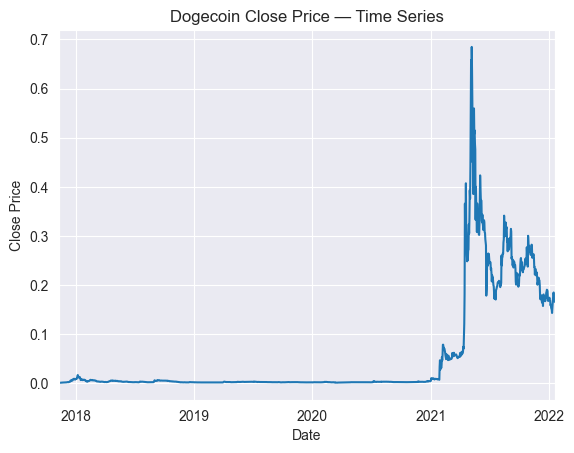

In [5]:
# Time-series line plot
fig, ax = plt.subplots()
df['Close'].plot(ax=ax, title='Dogecoin Close Price — Time Series')
ax.set_ylabel('Close Price')
plt.show()

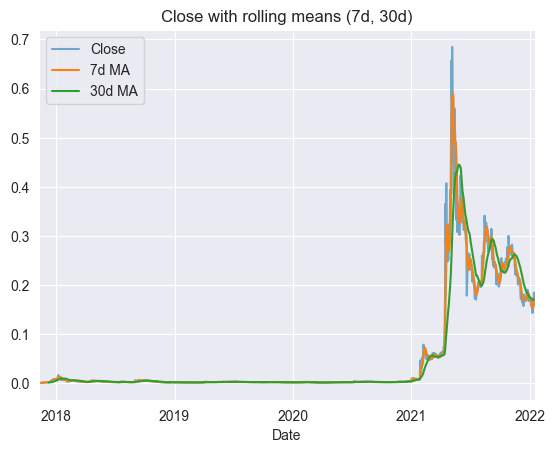

In [6]:
# Rolling stats: short and long window
fig, ax = plt.subplots()
df["Close"].plot(ax=ax, alpha=0.6, label='Close')
df["Close"].rolling(7).mean().plot(ax=ax, label='7d MA')
df["Close"].rolling(30).mean().plot(ax=ax, label='30d MA')
ax.legend()
ax.set_title('Close with rolling means (7d, 30d)')
plt.show()

### STL

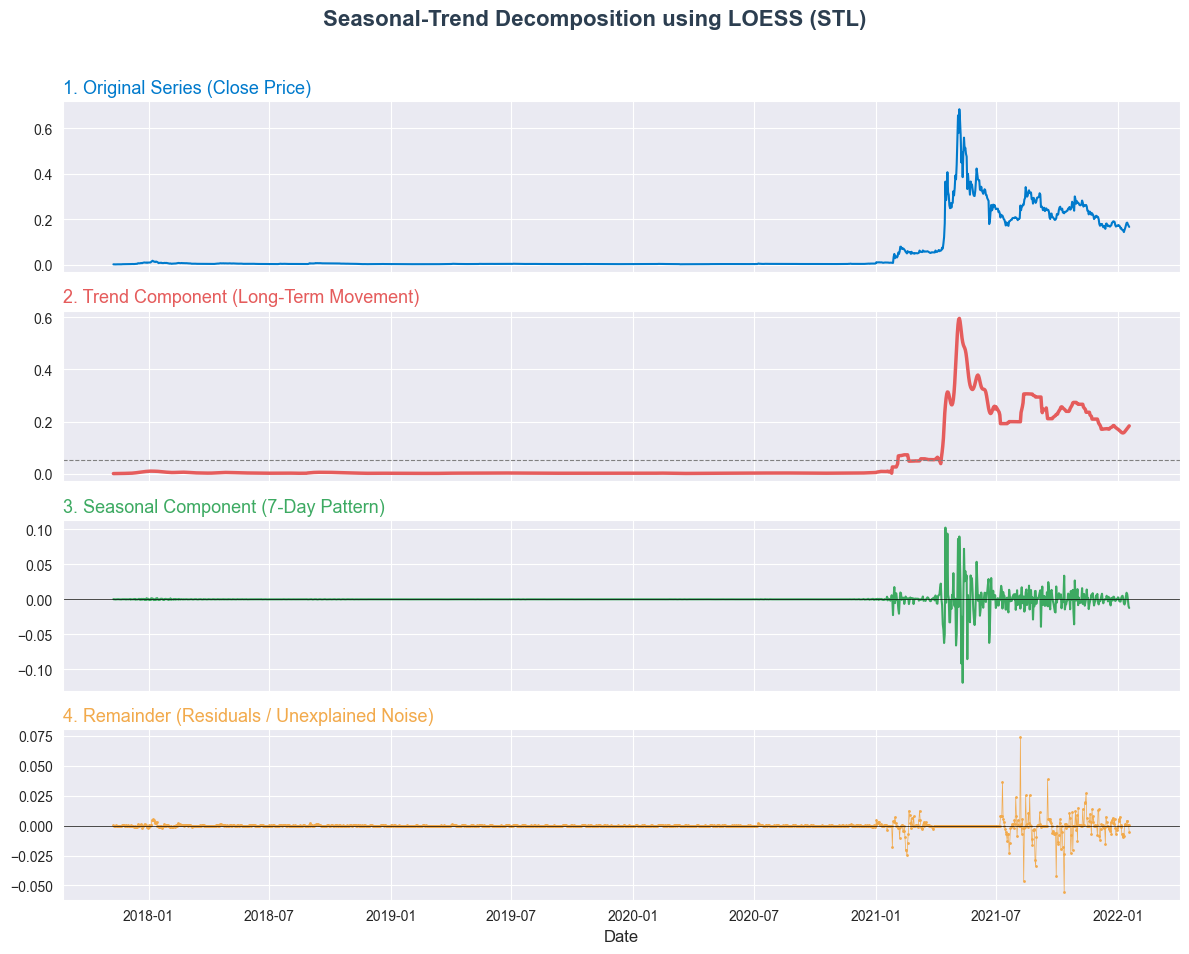

In [ ]:
from statsmodels.tsa.seasonal import STL
# Season value can be tuned
# We will be using robust to handle potential outliers in the data
stl = STL(df['Close'], seasonal=7, robust=True)
res = stl.fit()

# Define distinct colors for visual separation
COLOR_ORIGINAL = '#007ACC'  # Deep Blue
COLOR_TREND = '#E55C5C'     # Muted Red
COLOR_SEASONAL = '#3DAA62'  # Medium Green
COLOR_RESIDUAL = '#F2AA4C'  # Warm Orange

# Create the figure with 4 stacked subplots, sharing the x-axis (time)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Main Title for the Entire Figure
fig.suptitle('Seasonal-Trend Decomposition using LOESS (STL)', fontsize=16, fontweight='bold', color='#2c3e50')

# 1. Original Series
axes[0].plot(df.index, df['Close'], color=COLOR_ORIGINAL, linewidth=1.5)
axes[0].set_title('1. Original Series (Close Price)', fontsize=13, loc='left', color=COLOR_ORIGINAL)
axes[0].tick_params(axis='y', labelsize=10)

# 2. Trend Component
axes[1].plot(df.index, res.trend, color=COLOR_TREND, linewidth=2.5)
axes[1].set_title('2. Trend Component (Long-Term Movement)', fontsize=13, loc='left', color=COLOR_TREND)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].axhline(y=res.trend.mean(), color='grey', linestyle='--', linewidth=0.8) # Optional mean line

# 3. Seasonal Component
axes[2].plot(df.index, res.seasonal, color=COLOR_SEASONAL, linewidth=1.5)
axes[2].set_title('3. Seasonal Component (7-Day Pattern)', fontsize=13, loc='left', color=COLOR_SEASONAL)
axes[2].tick_params(axis='y', labelsize=10)
axes[2].axhline(0, color='black', linewidth=0.5)

# 4. Residual Component (The "Loss" or Remainder)
axes[3].plot(df.index, res.resid, color=COLOR_RESIDUAL, linewidth=0.5, marker='.', markersize=2)
axes[3].set_title('4. Remainder (Residuals / Unexplained Noise)', fontsize=13, loc='left', color=COLOR_RESIDUAL)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].axhline(0, color='black', linewidth=0.5)

# Final Layout Adjustments
plt.xlabel('Date', fontsize=12)
# Improve the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### Autocorrelation

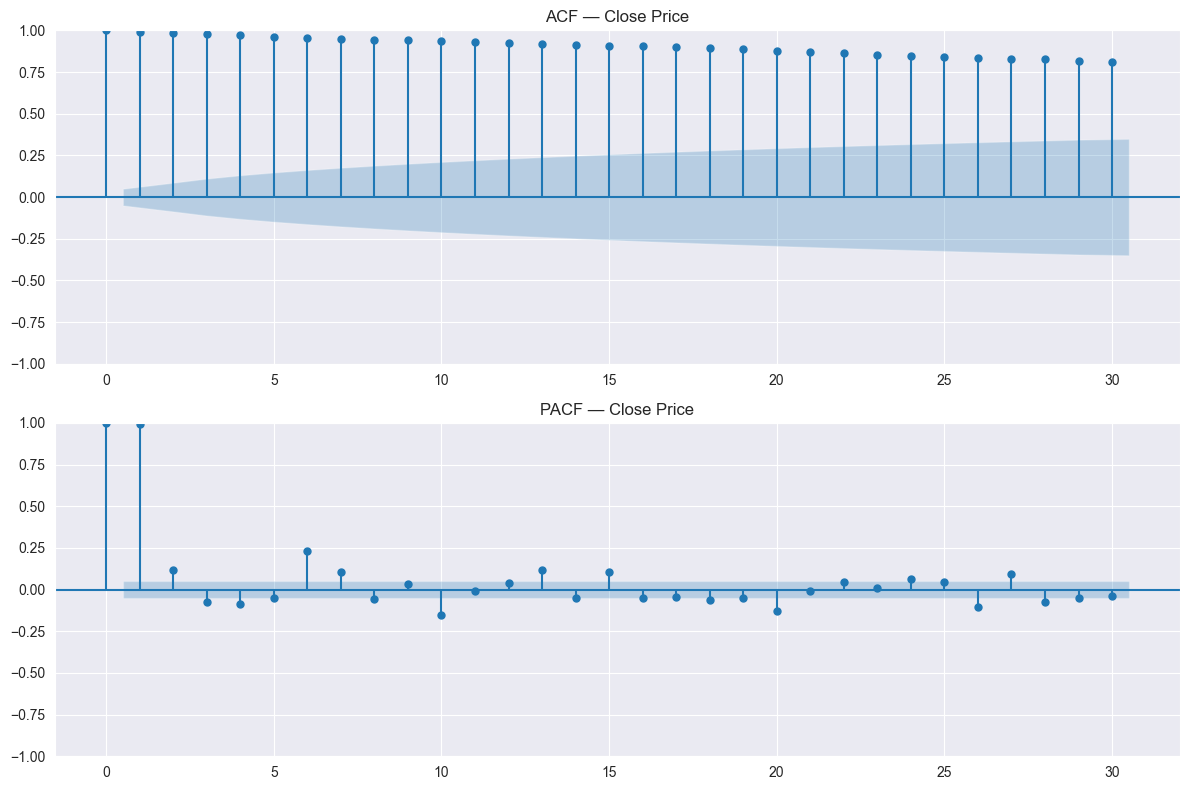

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 30
# ACF and PACF plots (lags in days)
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['Close'].dropna(), ax=ax[0], lags=nlags)
ax[0].set_title('ACF — Close Price')

plot_pacf(df['Close'].dropna(), ax=ax[1], lags=nlags) 
ax[1].set_title('PACF — Close Price')
plt.tight_layout()
plt.show()


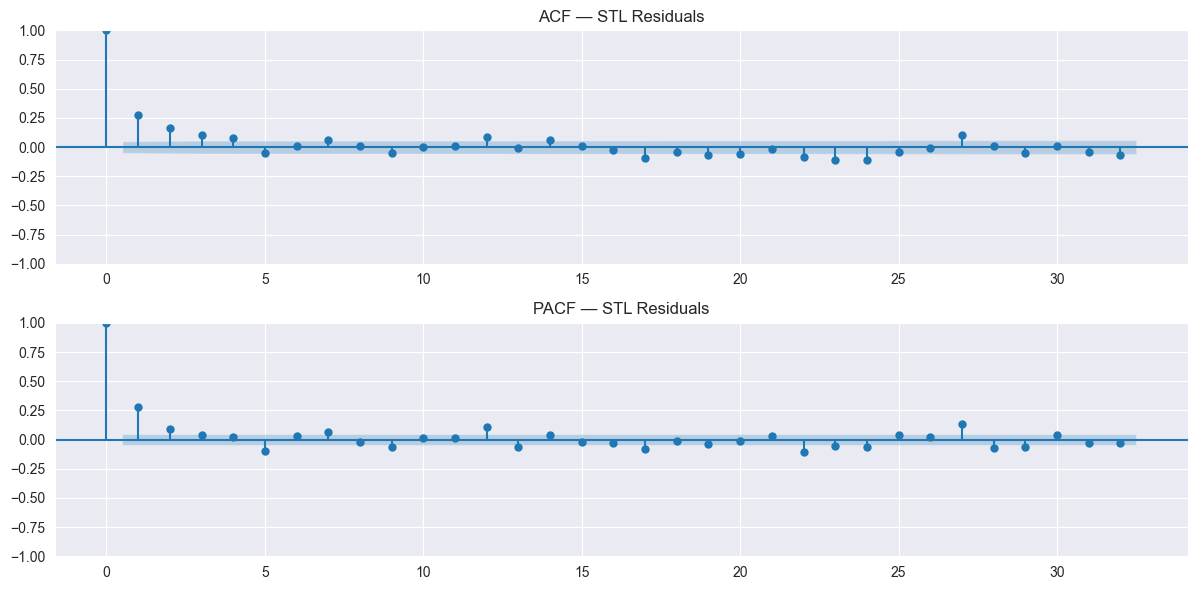

In [12]:
# Also check on residuals from STL to see if the decomposition removed autocorrelation
fig, ax = plt.subplots(2,1, figsize=(12,6))
plot_acf(res.resid.dropna(), ax=ax[0])
ax[0].set_title('ACF — STL Residuals')
plot_pacf(res.resid.dropna(), ax=ax[1])
ax[1].set_title('PACF — STL Residuals')
plt.tight_layout()
plt.show()